In [4]:
import os
import cv2
import numpy as np
import pandas as pd
import datetime
from skimage.feature import local_binary_pattern, hog
from skimage import color
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

Importing Dataset


In [ ]:
def load_dataset(dataset_path):
    images = []
    labels = []
    # Each subdirectory is a class corresponding to a person
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Only consider JPG images
            for file in os.listdir(person_path):
                if file.lower().endswith(".jpg"):
                    img_path = os.path.join(person_path, file)
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
                        labels.append(person)
    return images, labels


dataset_path = 'project_data/lfw-deepfunneled/lfw-deepfunneled'
images, labels = load_dataset(dataset_path)
print(f"Loaded {len(images)} images for {len(set(labels))} persons.")


In [ ]:
print("Number of images:", len(images))
print("Number of labels:", len(labels))
print("size of images:", images[0].shape)

Face Detection and Cropping (For Avoiding Background Noise)

No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Abdullah_Gul\Abdullah_Gul_0015.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Andy_Roddick\Andy_Roddick_0010.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Ariel_Sharon\Ariel_Sharon_0017.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Arnold_Schwarzenegger\Arnold_Schwarzenegger_0036.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Augustin_Calleri\Augustin_Calleri_0002.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Barbara_Boxer\Barbara_Boxer_0001.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Barbara_Esbin\Barbara_Esbin_0001.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Ben_Curtis\Ben_Curtis_0001.jpg
No face detected in image: project_data/lfw-deepfunneled/lfw-deepfunneled\Ben_Glisan\Ben_Glisan_0001.j

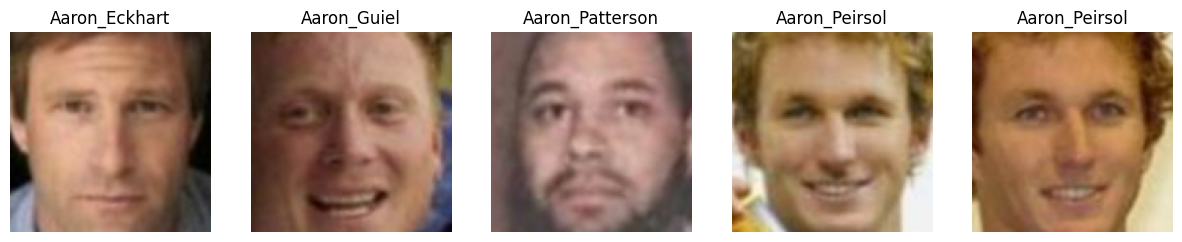

In [6]:
import os
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image in BGR format.
    - cascade_path: Name of the Haar cascade XML file (default is for frontal face detection).
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for detection
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces (tweak scaleFactor, minNeighbors, minSize as needed)
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        return None, faces

    # Option: Choose the largest detected face
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    return face_resized, faces

def load_dataset_with_face_detection(dataset_path):
    """
    Loads images from a dataset folder with one subfolder per person, applies face detection and cropping,
    and returns lists of cropped face images and corresponding labels.
    
    Parameters:
    - dataset_path: Path to the main dataset folder.
    
    Returns:
    - cropped_images: List of cropped face images.
    - labels: List of labels corresponding to each image.
    """
    cropped_images = []
    labels = []
    
    # Iterate over each person's folder
    for person in os.listdir(dataset_path):
        person_path = os.path.join(dataset_path, person)
        if os.path.isdir(person_path):
            # Process only .jpg files
            for file in os.listdir(person_path):
                if file.lower().endswith('.jpg'):
                    img_path = os.path.join(person_path, file)
                    image = cv2.imread(img_path)
                    if image is None:
                        continue
                    # Apply face detection and crop the face
                    face, _ = detect_and_crop_face(image)
                    if face is not None:
                        cropped_images.append(face)
                        labels.append(person)
                    else:
                        print(f"No face detected in image: {img_path}")
    
    return cropped_images, labels

def display_images(images, labels, num_samples=5):
    """
    Displays a few sample images with their labels in a Jupyter Notebook using Matplotlib.
    
    Parameters:
    - images: List of images in BGR format.
    - labels: Corresponding labels.
    - num_samples: Number of samples to display.
    """
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        img = images[i]
        label = labels[i]
        # Convert from BGR to RGB for correct color display
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_rgb)
        plt.title(label)
        plt.axis('off')
    plt.show()

# Example usage in a Jupyter Notebook:
dataset_path = 'project_data/lfw-deepfunneled/lfw-deepfunneled'  # Update with your dataset location
images, labels = load_dataset_with_face_detection(dataset_path)
print(f"Loaded {len(images)} cropped face images for {len(set(labels))} persons.")

# Display a few sample images inline
display_images(images, labels, num_samples=5)


Example usage of face detection and cropping

Detected 2 face(s) in the image.
Detected face: [[[245 251 250]
  [241 247 246]
  [243 249 248]
  ...
  [248 250 250]
  [248 250 250]
  [248 250 250]]

 [[249 254 252]
  [242 249 246]
  [242 251 248]
  ...
  [250 250 250]
  [250 250 250]
  [250 250 250]]

 [[248 253 251]
  [244 249 247]
  [241 250 247]
  ...
  [249 249 249]
  [250 250 250]
  [250 250 250]]

 ...

 [[246 246 246]
  [246 246 246]
  [245 245 245]
  ...
  [236 236 236]
  [237 237 237]
  [235 237 237]]

 [[248 246 246]
  [246 246 246]
  [245 245 245]
  ...
  [238 236 236]
  [237 237 237]
  [235 237 237]]

 [[248 246 246]
  [246 246 246]
  [245 245 245]
  ...
  [238 236 236]
  [236 236 236]
  [235 237 237]]]
Detected face shape: (132, 132, 3)


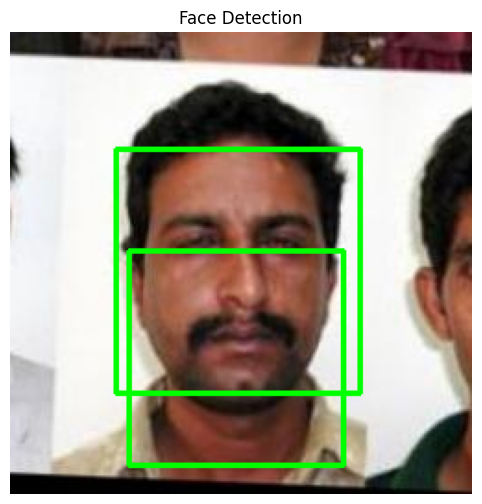

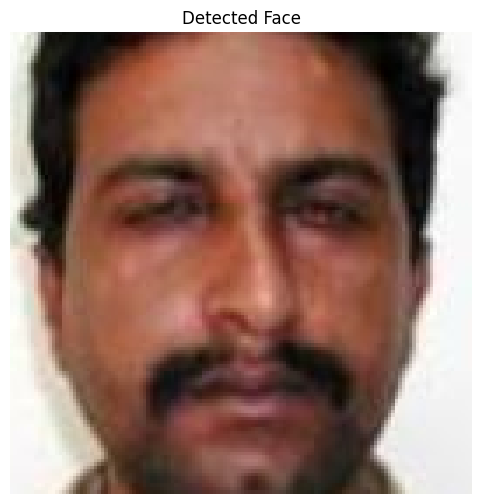

In [7]:
import cv2
import matplotlib.pyplot as plt

def detect_and_crop_face(image, cascade_path='haarcascade_frontalface_default.xml'):
    """
    Detects faces in an image using Haar cascades and returns the cropped face region.
    
    Parameters:
    - image: Input image (BGR format)
    - cascade_path: Filename for the Haar cascade XML file.
    
    Returns:
    - face_roi: Cropped face region if a face is detected; otherwise, returns None.
    - faces: List of detected face bounding boxes.
    """
    # Convert image to grayscale for the face detector
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Load Haar cascade from OpenCV's data directory
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + cascade_path)
    
    # Detect faces: adjust scaleFactor and minNeighbors as needed
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("No faces detected.")
        return None, faces

    # For demonstration, take the first detected face (or choose the largest face)
    (x, y, w, h) = sorted(faces, key=lambda b: b[2] * b[3], reverse=True)[0]
    face_roi = image[y:y+h, x:x+w]
    face_resized = cv2.resize(face_roi, (128, 128))
    # return face_resized, faces
    return face_roi, faces

def show_image(title, image, cmap=None):
    """
    Displays an image using Matplotlib.
    
    Parameters:
    - title: Title of the plot.
    - image: Image array.
    - cmap: Color map (if needed, e.g., 'gray' for grayscale images).
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(image, cmap=cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage in Jupyter Notebook:
img_path = 'project_data\lfw-deepfunneled\lfw-deepfunneled\Zulfiqar_Ahmed\Zulfiqar_Ahmed_0001.jpg'  # Update with your image path
image = cv2.imread(img_path)

if image is None:
    print("Image not found or unable to load.")
else:
    face, faces = detect_and_crop_face(image)
    print(f"Detected {len(faces)} face(s) in the image.")
    print(f"Detected face: {face}")
    print(f"Detected face shape: {face.shape if face is not None else None}")
    
    # Convert images from BGR to RGB for proper display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    if face is not None:
        face_rgb = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
        # Draw rectangles on the original image for visualization
        for (x, y, w, h) in faces:
            cv2.rectangle(image_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)
        
        # Display the original image with detected face boxes
        show_image("Face Detection", image_rgb)
        
        # Display the cropped face
        show_image("Detected Face", face_rgb)
    else:
        print("No face detected in the image.")


Seeing how an image is  resized

Original image shape: (250, 250, 3)
Resized image shape: (200, 200, 3)


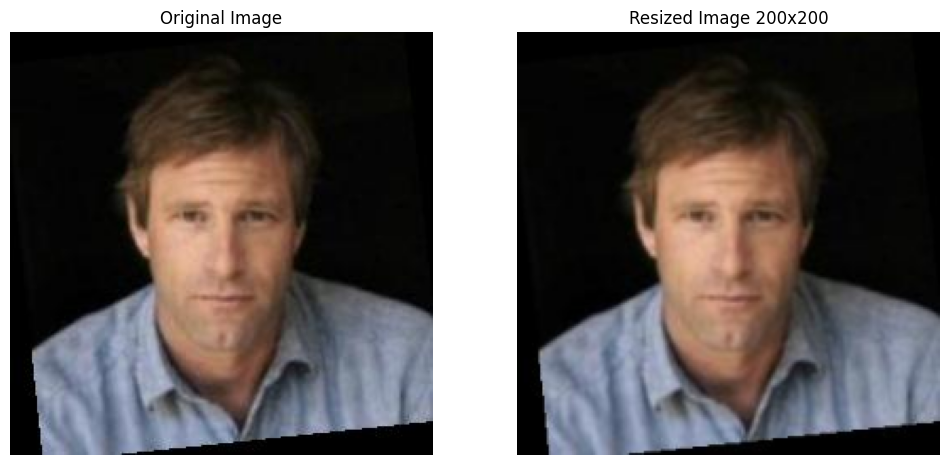

In [8]:
import cv2
import matplotlib.pyplot as plt

# Load the image (update 'path/to/your/image.jpg' with your image path)
image = cv2.imread('project_data\lfw-deepfunneled\lfw-deepfunneled\Aaron_Eckhart\Aaron_Eckhart_0001.jpg')

# Check if image was loaded
if image is None:
    print("Image not found or unable to load.")
else:
    # Print the original image dimensions
    print("Original image shape:", image.shape)

    # Define the target size (width, height)
    target_size = (200, 200)

    # Resize the image to the target size
    resized_image = cv2.resize(image, target_size)
    print("Resized image shape:", resized_image.shape)

    # Convert images from BGR (OpenCV default) to RGB for correct display in Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

    # Display the original and resized images side by side
    plt.figure(figsize=(12, 6))

    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis('off')

    # Resized image
    plt.subplot(1, 2, 2)
    plt.imshow(resized_rgb)
    plt.title(f"Resized Image {target_size[0]}x{target_size[1]}")
    plt.axis('off')

    plt.show()


In [9]:
print(images[0].shape)
print(images[0])
print(images[1])
print(labels[0])
print(labels[1])

(128, 128, 3)
[[[ 28  42  54]
  [ 33  46  61]
  [ 37  52  68]
  ...
  [ 25  36  41]
  [ 24  35  38]
  [ 23  35  37]]

 [[ 27  41  53]
  [ 33  46  61]
  [ 38  52  68]
  ...
  [ 25  35  41]
  [ 23  35  38]
  [ 22  34  36]]

 [[ 26  40  52]
  [ 32  45  60]
  [ 37  52  68]
  ...
  [ 25  35  40]
  [ 23  34  37]
  [ 21  33  35]]

 ...

 [[173 154 141]
  [171 153 139]
  [173 154 141]
  ...
  [ 78  72  64]
  [ 80  75  66]
  [ 82  77  68]]

 [[174 155 142]
  [171 151 138]
  [172 153 140]
  ...
  [ 79  73  65]
  [ 82  76  67]
  [ 84  78  69]]

 [[176 154 142]
  [170 150 137]
  [170 151 138]
  ...
  [ 83  76  68]
  [ 85  78  69]
  [ 87  80  71]]]
[[[27 37 54]
  [28 40 58]
  [28 40 58]
  ...
  [25 52 72]
  [27 54 74]
  [30 57 77]]

 [[26 38 55]
  [30 42 60]
  [30 42 61]
  ...
  [16 41 61]
  [18 44 64]
  [22 49 69]]

 [[27 39 57]
  [30 42 61]
  [30 43 62]
  ...
  [19 44 63]
  [21 47 65]
  [24 52 70]]

 ...

 [[27 34 69]
  [34 41 76]
  [37 44 80]
  ...
  [25 10 11]
  [18  7  6]
  [14  3  3]]

 [[27 

Extracting LBP features of the Images

In [12]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern

def extract_lbp_features(image, radius=1, n_points=8):
    """
    Extract LBP features from an image.
    
    Parameters:
    - image: Input image in BGR or grayscale.
    - radius: Radius of circle (in pixels) for LBP.
    - n_points: Number of points to consider around each pixel.
    
    Returns:
    - hist: Normalized histogram of LBP features.
    """
    # If the image has 3 channels, convert it to grayscale
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    # Compute the LBP representation of the image using the "uniform" method
    lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
    
    # Calculate the number of bins. For uniform LBP, the number of bins is n_points + 2
    n_bins = int(n_points + 2)
    
    # Build a histogram of the LBP values
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
    
    # Normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    
    return hist

# Example usage:
example_image = cv2.imread('project_data\lfw-deepfunneled\lfw-deepfunneled\Zach_Parise\Zach_Parise_0001.jpg')
lbp_features = extract_lbp_features(example_image)
print("LBP features:", lbp_features)
print("LBP features shape:", lbp_features.shape)


LBP features: [0.00824  0.037824 0.015312 0.085536 0.245392 0.196112 0.052624 0.05176
 0.25808  0.04912 ]
LBP features shape: (10,)


HoG features of the images


In [13]:
from skimage.feature import hog

def extract_hog_features(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9):
    """
    Extract HoG features from an image.
    
    Parameters:
    - image: Input image in BGR format.
    - pixels_per_cell: Size (in pixels) of a cell.
    - cells_per_block: Number of cells in each block.
    - orientations: Number of gradient orientations.
    
    Returns:
    - hog_features: A feature vector containing the HoG features.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Compute the HoG features
    hog_features = hog(gray,
                       orientations=orientations,
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block,
                       block_norm='L2-Hys',
                       visualize=False,
                       feature_vector=True)
    
    return hog_features

# Example usage:
hog_features = extract_hog_features(example_image)
print("HoG features:", hog_features)
print("HoG features shape:", hog_features.shape)

HoG features: [0.         0.         0.         ... 0.07919211 0.         0.        ]
HoG features shape: (32400,)


Extracting CNN features for the images


Method-1 Using Pretrained VGG-16 Model


In [80]:
# Load the pre-trained VGG16 model with the top (classification layers) removed
cnn_model = VGG16(weights='imagenet', include_top=False)

def extract_cnn_features(image, target_size=(224, 224)):
    """
    Extracts CNN features from an image using a pre-trained VGG16 model.

    Parameters:
    - image: Input image in BGR format (as loaded by cv2).
    - target_size: The size to which the image should be resized (default: (224, 224)).

    Returns:
    - A 1D flattened feature vector extracted from VGG16.
    """
    # Resize image to match VGG16 input size
    resized = cv2.resize(image, target_size)
    
    # Convert BGR (OpenCV format) to RGB (expected by VGG16)
    rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    
    # Expand dimensions to create a batch of size 1
    expanded = np.expand_dims(rgb, axis=0)
    
    # Preprocess the image using VGG16's preprocess_input
    preprocessed = preprocess_input(expanded)
    
    # Extract CNN features using the pre-trained model
    features = cnn_model.predict(preprocessed,verbose=1)
    
    return features.ravel()

# Example usage:
cnn_features = extract_cnn_features(example_image)
print("Flattened CNN feature vector shape:",cnn_features.shape)
print("Total size:", cnn_features.size)
print("CNN feature map shape:", features.shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
Flattened CNN feature vector shape: (25088,)
Total size: 25088
CNN feature map shape: (1, 7, 7, 512)


Applying on complete dataset

In [ ]:
# def extract_all_features(images):
#     """
#     images: NumPy array of shape (n_samples, 128, 128, 3)
#     Returns: combined features of shape (n_samples, combined_feature_length)
#     """
#     all_features = []
#     for idx, img in enumerate(images):
#         # Extract features from each image
#         pixel_feat = img.flatten()
#         hog_feat = extract_hog_features(img)
#         bnp_feat = extract_lbp_features(img)
#         cnn_feat = extract_cnn_features(img)
        
#         # Concatenate all features into one vector
#         combined = np.concatenate([pixel_feat, hog_feat, bnp_feat, cnn_feat])
#         all_features.append(combined)
#     return np.array(all_features)

Faster

In [81]:
import multiprocessing
from concurrent.futures import ThreadPoolExecutor

def extract_all_features(images, batch_size=32, num_workers=4):
    """
    Efficiently extracts and combines features from a batch of images.

    Parameters:
    - images: NumPy array of shape (n_samples, 128, 128, 3)
    - batch_size: Number of images processed at once for CNN features
    - num_workers: Number of parallel threads for HOG & LBP feature extraction

    Returns:
    - NumPy array of shape (n_samples, combined_feature_length)
    """
    n_samples = len(images)

    # Precompute feature dimensions
    sample_img = images[0]
    pixel_feat_dim = sample_img.size
    hog_feat_dim = len(extract_hog_features(sample_img))
    lbp_feat_dim = len(extract_lbp_features(sample_img))
    cnn_feat_dim = len(extract_cnn_features(sample_img))  # Use your function here

    total_features = pixel_feat_dim + hog_feat_dim + lbp_feat_dim + cnn_feat_dim

    # Pre-allocate NumPy array for efficiency
    all_features = np.zeros((n_samples, total_features), dtype=np.float32)

    # Step 1: Extract Pixel, HOG, and LBP features in parallel
    def process_image(idx):
        img = images[idx]
        pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        lbp_feat = extract_lbp_features(img)
        return np.concatenate([pixel_feat, hog_feat, lbp_feat])

    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        pixel_hog_lbp_features = list(executor.map(process_image, range(n_samples)))

    # Store extracted features
    all_features[:, :len(pixel_hog_lbp_features[0])] = np.array(pixel_hog_lbp_features)

    # Step 2: Extract CNN features in batches (since CNN inference is usually slow)
    for i in range(0, n_samples, batch_size):
        batch_images = images[i:i + batch_size]

        # Run CNN feature extraction on batch
        batch_cnn_features = np.array([extract_cnn_features(img) for img in batch_images])

        # Store CNN features in preallocated array
        all_features[i:i + batch_size, -cnn_feat_dim:] = batch_cnn_features

    return all_features

In [ ]:
features=extract_all_features(images)
print("Features shape:", features.shape)

Without CNN

In [14]:
def extract_all_features_no_cnn(images):
    """
    images: NumPy array of shape (n_samples, 128, 128, 3)
    Returns: combined features of shape (n_samples, combined_feature_length)
    """
    all_features = []
    for idx, img in enumerate(images):
        # Extract features from each image
        pixel_feat = img.flatten()
        hog_feat = extract_hog_features(img)
        bnp_feat = extract_lbp_features(img)
        # cnn_feat = extract_cnn_features(img)
        
        # Concatenate all features into one vector
        combined = np.concatenate([pixel_feat, hog_feat, bnp_feat])
        all_features.append(combined)
    return np.array(all_features)

In [15]:
without_cnn_features=extract_all_features_no_cnn(images)
print("Features shape:", without_cnn_features.shape)

Features shape: (13149, 57262)


Creating Dataframe 

In [34]:
import pandas as pd

df = pd.DataFrame(without_cnn_features)

# Generate column names for features
df.columns = [f'feature_{i}' for i in range(without_cnn_features.shape[1])]

# Add the labels column
df['label'] = labels  # Ensure 'labels' has the same length as features

# Display the shape to confirm
print("DataFrame shape:", df.shape)

# Show first few rows
print(df.head())


DataFrame shape: (13149, 57263)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0       28.0       42.0       54.0       33.0       46.0       61.0   
1       27.0       37.0       54.0       28.0       40.0       58.0   
2       89.0       93.0      121.0       89.0       93.0      121.0   
3      152.0      181.0      185.0      122.0      153.0      158.0   
4       37.0       86.0      126.0       28.0       77.0      117.0   

   feature_6  feature_7  feature_8  feature_9  ...  feature_57253  \
0       37.0       52.0       68.0       42.0  ...       0.024048   
1       28.0       40.0       58.0       27.0  ...       0.022583   
2       89.0       93.0      121.0       89.0  ...       0.018982   
3       86.0      120.0      126.0       59.0  ...       0.026367   
4       23.0       73.0      113.0       25.0  ...       0.028809   

   feature_57254  feature_57255  feature_57256  feature_57257  feature_57258  \
0       0.021667       0.121033       0.440552

OneHotEncoding for labels


In [ ]:
# from sklearn.preprocessing import OneHotEncoder

# # Apply One-Hot Encoding
# one_hot_encoder = OneHotEncoder(sparse_output=False) 
# encoded_labels = one_hot_encoder.fit_transform(df[['label']])  # Convert labels to one-hot encoding

# # Convert to DataFrame with proper column names
# label_columns = [f'label_{i}' for i in range(encoded_labels.shape[1])]

# df_encoded = pd.DataFrame(encoded_labels, columns=label_columns)

# # Drop original label column and concatenate encoded labels
# df = df.drop(columns=['label'])
# df = pd.concat([df, df_encoded], axis=1)


In [ ]:
# print(df.head())  # Display first few rows

In [36]:
from sklearn.model_selection import train_test_split

# Features (X) and Labels (y)
# num_classes = len(set(labels))
# X = df.drop(columns=[f"label_{i}" for i in range(num_classes)])  # Feature matrix
# y = df[[f"label_{i}" for i in range(num_classes)]]  # One-hot encoded labels

X=df.drop(columns=['label'])
y=df['label']

# Train-Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")


Training set size: (10519, 57262), Test set size: (2630, 57262)


Applying ML model